# Anomaly Detection for Santa Cruz Islands Animl Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Label Cleaning & EDA
Clean up the labels and visualize the species distribution.

In [2]:
labels_df = pd.read_csv('SCI_biodiversity_images_and_labels.csv')
labels_df.head()

,image_path,species_label
0,cropped_images/sci_biosecurity-c3ae90a3d9a22d9...,fox
1,cropped_images/sci_biosecurity-0e1bb2d5f0cfaad...,opossum
2,cropped_images/sci_biosecurity-fe89dfedaa00dc1...,opossum
3,cropped_images/sci_biosecurity-d1a8ad87dd68a02...,opossum
4,cropped_images/sci_biosecurity-8eec8e106a41356...,fox


In [3]:
print(f"Total number of images after cropping = {labels_df.shape[0]}")

Total number of images after cropping = 109903


In [4]:
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'bug', 'rodnet', 'liz', 'butterfly', 'frog',
       'striped skunk'], dtype=object)

In [5]:
# clean label typos
clean_labels = {'liz':'lizard', 'rodnet':'rodent', 'striped skunk': 'skunk', 'bug':'insect'}
labels_df['species_label'] = labels_df['species_label'].apply(lambda x: clean_labels.get(x, x))
labels_df['species_label'].unique()

array(['fox', 'opossum', 'rodent', 'bird', 'rat', 'skunk', 'scrub jay',
       'lizard', 'mouse', 'dog', 'vole', 'insect', 'squirrel', 'bat',
       'snake', 'butterfly', 'frog'], dtype=object)

In [6]:
# only keep the most specific species categories (for example: mouse, rat not rodent)
keep_labels = ['fox', 'opossum', 'rat', 'skunk', 'scrub jay', 'lizard', 'mouse', 'dog', 'vole', 'squirrel', 'bat',
               'snake', 'butterfly', 'frog']
filtered_labels_df = labels_df[labels_df['species_label'].isin(keep_labels)]
print(f"Total number of images after filtering top-level species = {filtered_labels_df.shape[0]}")

Total number of images after filtering top-level species = 28731


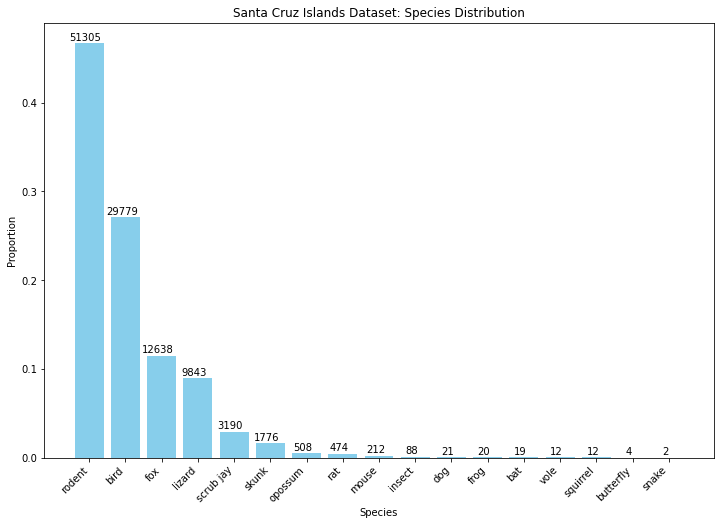

In [7]:
# visualize species distribution - before
species_proportions = labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

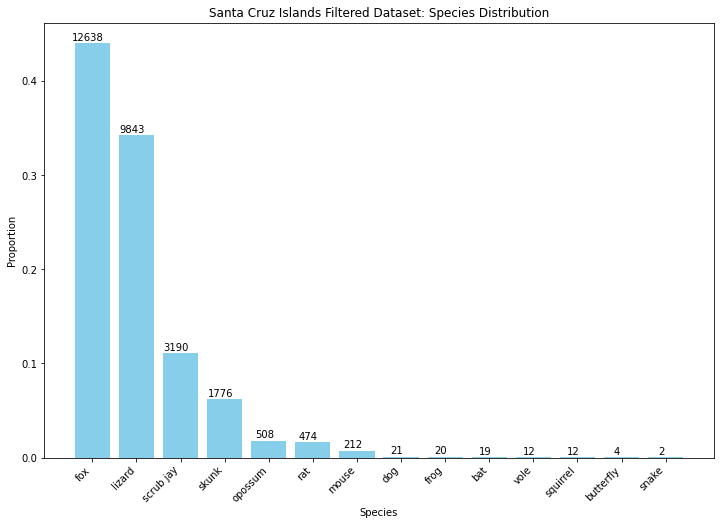

In [8]:
# visualize species distribution - after
species_proportions = filtered_labels_df['species_label'].value_counts(normalize=True).reset_index()
species_proportions.columns = ['species', 'proportion']

plt.figure(figsize=(12, 8))
bars = plt.bar(species_proportions['species'], species_proportions['proportion'], color='skyblue')

# annotating each bar with its count
for bar, count in zip(bars, filtered_labels_df['species_label'].value_counts()):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.001, f'{count}', ha='center', va='bottom')

plt.xlabel('Species')
plt.ylabel('Proportion')
plt.title('Santa Cruz Islands Filtered Dataset: Species Distribution')
plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
# based on the species proportions let's hold out the low volume species as invasive
invasive = ['dog','frog','bat','vole','squirrel','butterfly','snake']
non_invasive = ['fox','lizard','scrub jay','skunk','opossum','rat','mouse']

# 2. Anomaly detection with hold out set
For each "invasive" species, we train an autoencoder on the other ("native") species (hold out the "invasive" species). During the training process, we calculate a correlation threshold which is the correlation between the original "native" species data and the trained autoencoder repersentation of the "native" species data. We can further weight this correlation with a constant c. Then during inference, we use our trained autoencoder to predict a repersentation of the "invasive" species. If the correlation between the autoencoder repersentation and original "invasive" species data is less than the correlation threshold scaled by some constant c, it is predicted as an "anomlous" or "invasive" species, otherwise it is a "native" species. We can hyperparameter tune for the value of c.

In [31]:
def resize_images_batch(filepaths, target_size):
    images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        images.append(img/255)
    return np.array(images)

def generate_batches(filepaths, batch_size, target_size):
    while True: 
        for i in range(0, len(filepaths), batch_size):
            batch_paths = filepaths[i:i + batch_size]
            batch_images = resize_images_batch(batch_paths, target_size)
            batch_images_flat = batch_images.reshape(batch_images.shape[0], -1)
            yield batch_images_flat, batch_images_flat

def create_autoencoder(input_dim, layers):
    total = len(layers)
    autoencoder = Sequential()

    autoencoder.add(Input(shape=(input_dim,))) # input layer

    for l in range(0, total):
        units = layers[l]
        autoencoder.add(Dense(units, activation='relu'))

    autoencoder.add(Dense(input_dim, activation='softmax'))  # output layer

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

def train_autoencoder_generator(train_data_paths, target_size, layers, epochs=5, batch_size=32):
    input_dim = target_size[0] * target_size[1] * 3
    autoencoder = create_autoencoder(input_dim, layers)

    autoencoder.fit(
    generate_batches(train_data_paths, batch_size, target_size),
    steps_per_epoch=len(train_data_paths) // batch_size,
    epochs=epochs,
    verbose=2)

    return autoencoder

In [32]:
def resize_images(filepaths, target_size):
    images = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        images.append(img/255)
    return np.array(images)

def get_predictions(autoencoder, target_size, train_data_paths, invasive_data_paths):
    last_layer = autoencoder.layers[-1]
    encoder_model = Model(inputs=autoencoder.input, outputs=last_layer.output)

    # predict on invasive images
    invasive_images = resize_images(invasive_data_paths, target_size)
    invasive_images_flat = invasive_images.reshape(invasive_images.shape[0], -1)
    encoded_invasive = encoder_model.predict(invasive_images_flat)
    
    # predict on native images and get train_correlation
    native_images = resize_images(train_data_paths, target_size)
    native_images_flat = native_images.reshape(native_images.shape[0], -1)
    encoded_native = encoder_model.predict(native_images_flat)
    train_correlation = np.corrcoef(native_images_flat, encoded_native, rowvar=False)
    train_correlation = train_correlation[:native_images_flat.shape[0], native_images_flat.shape[0]:]

    return train_correlation, invasive_images_flat, encoded_invasive, encoded_native


def plot_tsne(encoded_native, encoded_invasive, title):
    tsne = TSNE(n_components=2, perplexity = encoded_invasive.shape[0]-1, random_state=42)
    tsne_result_native = tsne.fit_transform(encoded_native)
    tsne_result_invasive = tsne.fit_transform(encoded_invasive)

    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_result_native[:, 0], tsne_result_native[:, 1], label='Native Species', alpha=0.7)
    plt.scatter(tsne_result_invasive[:, 0], tsne_result_invasive[:, 1], label='Invasive Species', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()

def compute_accuracy_correlation(train_corr, invasive_data_flat, encoded_invasive, c_list, title):
    correlation_invasive = np.corrcoef(invasive_data_flat, encoded_invasive, rowvar=False)
    correlation_invasive = correlation_invasive[:invasive_data_flat.shape[0], invasive_data_flat.shape[0]:]

    inv_accs = []
    thresholds = []
    for c in c_list:
        t = c*train_corr
        thresholds.append(t)
        invasive_predictions = np.where(correlation_invasive < t, 1, 0)
        inv_accs.append(np.sum(invasive_predictions == 1) / len(invasive_predictions))

    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, inv_accs, marker = 'o')
    plt.annotate(f'train_corr = {train_corr}', xy=(1, 1), xytext=(-10, -10), ha='right', va='top', textcoords='axes fraction', fontsize=8)
    plt.title(title)
    plt.xlabel("Correlation Threshold (c*train_corr)")
    plt.ylabel("Accuracy")
    plt.show()
    return inv_accs


In [ ]:

layers = [64, 32, 64]
target_size=(64, 64)

# train autoencoder and plot tsne results for each invasive species
models = {}
corr_results = {}
for invasive_species in invasive:
    invasive_data = filtered_labels_df[filtered_labels_df['species_label'] == invasive_species]
    native_data = filtered_labels_df[filtered_labels_df['species_label'] != invasive_species]

    train_data_paths = native_data['image_path']
    invasive_data_paths = invasive_data['image_path']

    autoencoder = train_autoencoder_generator(train_data_paths, target_size, layers)
    models[invasive_species] = autoencoder

    # results
    train_corr, invasive_data_flat, encoded_invasive, encoded_native = get_predictions(autoencoder, target_size, train_data_paths, invasive_data_paths)
    c_list = np.arange(.1, 1.1, .1)
    corr_title = f"Invasive Species Prediction Accuracy vs Correlation Thresholds - {invasive_species}"
    corr_invs_accs = compute_accuracy_correlation(train_corr, invasive_data_flat, encoded_invasive, c_list, corr_title)
    corr_results[invasive_species] = corr_invs_accs
    plot_tsne(encoded_native, encoded_invasive, f'TSNE Plot of Autoencoder Repersentations - {invasive_species}')


Epoch 1/5
897/897 - 127s - loss: 0.1764 - 127s/epoch - 142ms/step
Epoch 2/5
897/897 - 133s - loss: 0.1762 - 133s/epoch - 148ms/step
Epoch 3/5
897/897 - 126s - loss: 0.1761 - 126s/epoch - 141ms/step
Epoch 4/5
897/897 - 127s - loss: 0.1759 - 127s/epoch - 141ms/step
Epoch 5/5
897/897 - 114s - loss: 0.1762 - 114s/epoch - 128ms/step
898/898 [==============================] - 24s 27ms/step


Ideas:
1. fit autoencoder on all data (dont hold out invasive) and plot tsne and color code by species
2. fit autoencoder on big category (rat) and predict on small cateogry (rodent, mice, etc) and plot tsne

1/1 [==============================] - 0s 18ms/step


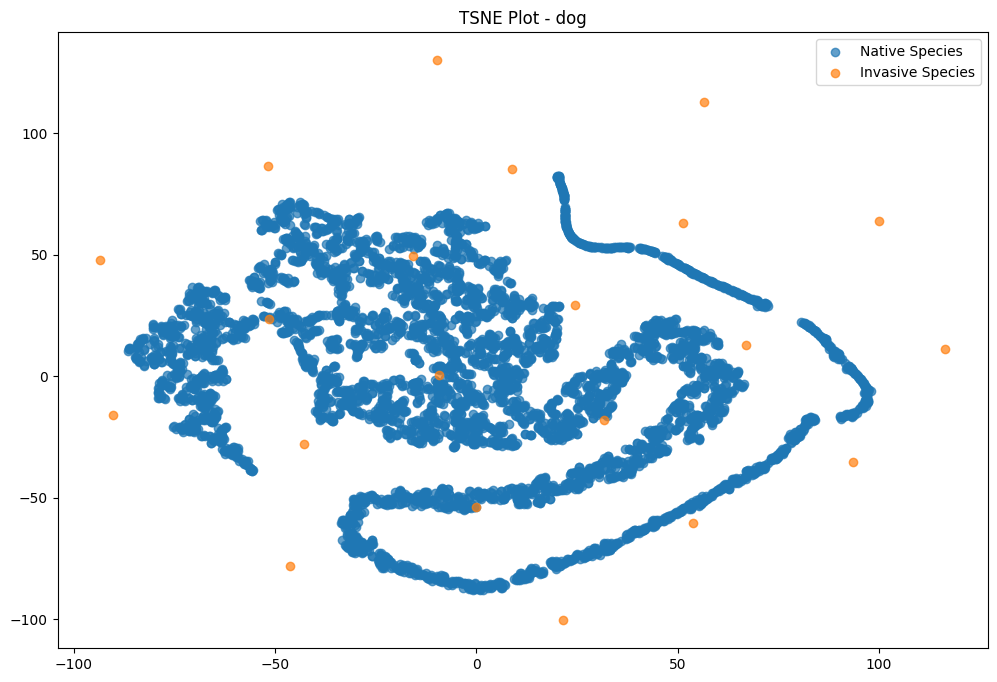

In [ ]:
plot_tsne(autoencoder, target_size, test_data_paths, invasive_data_paths, f'TSNE Plot - {invasive_species}')